In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

In [6]:

# Function to load CIFAR10 dataset
def load_data(batch_size):
    transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=4)
    
    print("Number of training examples: ", len(trainset))
    print("Number of test examples: ", len(testset))
    return trainloader, testloader

# Function to train the model
def train_model(model, trainloader, criterion, optimizer, device, num_epochs, testloader):
    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100.0 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        model.eval()
        val_loss, val_acc = validate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to validate the model
def validate_model(model, testloader, criterion, device):
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = validation_loss / len(testloader)
    val_acc = 100.0 * correct / total

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    return val_loss, val_acc

# Function to plot loss and accuracy
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, plot_name = None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

def df_model(with_batch_norm, device):
    if with_batch_norm:
        model = models.resnet50(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        model = model.to(device)
        return model
    else:
        model = models.resnet50(weights=None)
        model = remove_batch_norm_layers(model)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
        model = model.to(device)
        return model # Implement the model without batch normalization

def remove_batch_norm_layers(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, nn.Identity())
        else:
            remove_batch_norm_layers(module)
    return model


# Main function to run the training and validation
def main(model, batch_size, learning_rate, num_epochs, experiment_name, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    trainloader, testloader = load_data(batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, criterion, optimizer, device, num_epochs, testloader)

    # save the train-val loss and accuracy
    np.save(save_path + experiment_name + '_train_losses.npy', train_losses)
    np.save(save_path + experiment_name + '_train_accuracies.npy', train_accuracies)
    np.save(save_path + experiment_name + '_val_losses.npy', val_losses)
    np.save(save_path + experiment_name + '_val_accuracies.npy', val_accuracies)

    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, experiment_name)

    return train_losses, train_accuracies, val_losses, val_accuracies

if __name__ == '__main__':
    model = df_model(with_batch_norm=True, device=torch.device("cuda"))
    train_losses, train_accuracies, val_losses, val_accuracies = main(model, batch_size=256, learning_rate=0.001, num_epochs=100, experiment_name='resnet50_with_ADAM_with_batch_norm', save_path='./results/')

    model = df_model(with_batch_norm=False, device=torch.device("cuda"))
    train_losses, train_accuracies, val_losses, val_accuracies = main(model, batch_size=256, learning_rate=0.001, num_epochs=100, experiment_name='resnet50_with_ADAM_without_batch_norm', save_path='./results/')


### Ploting the result

In [4]:
val_losses = np.load('./src/results/resnet50_with_ADAM_with_batch_norm_val_losses.npy')
val_accuracies = np.load('./src/results/resnet50_with_ADAM_with_batch_norm_val_accuracies.npy')
val_losses_no_bn = np.load('./src/results/resnet50_with_ADAM_without_batch_norm_val_losses.npy')
val_accuracies_no_bn = np.load('./src/results/resnet50_with_ADAM_without_batch_norm_val_accuracies.npy')

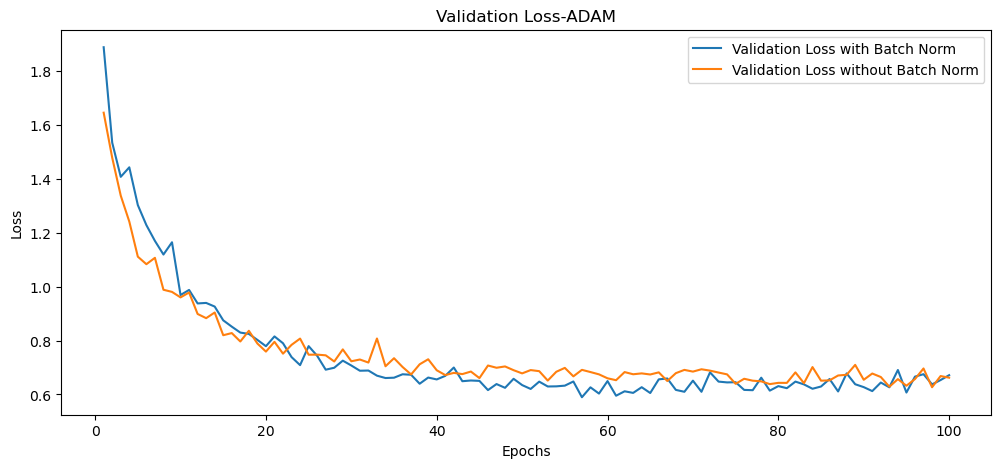

In [8]:
#plotting the results
epochs = range(1, len(val_losses) + 1)
plt.figure(figsize=(12, 5))
plt.plot(epochs, val_losses, label='Validation Loss with Batch Norm')
plt.plot(epochs, val_losses_no_bn, label='Validation Loss without Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss-ADAM')
plt.legend()

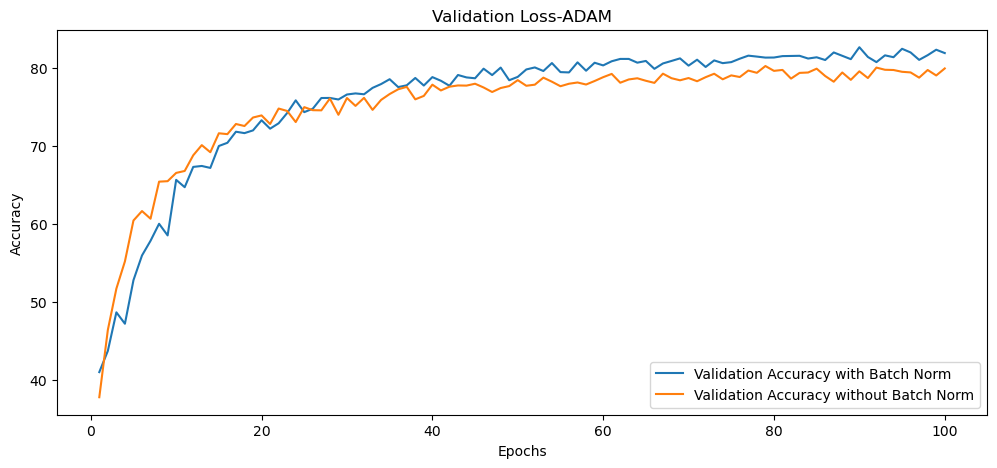

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(epochs, val_accuracies, label='Validation Accuracy with Batch Norm')
plt.plot(epochs, val_accuracies_no_bn, label='Validation Accuracy without Batch Norm')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Loss-ADAM')
plt.show()